In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns; sns.set()
import scipy

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess

In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
data = pd.read_pickle(fit_options.data_file)
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.000000,6326.00000,6326.000000,6326.000000,6326.0,6326.000000,6326.000000,6326.000000,6326.000000
mean,10.600221,604.489251,1.490831,604.527087,0.037836,3957.192539,3807.605275,12.229529,28.040942,37.740120,108.840500,1.017855,0.988552,0.994790,1.000917,1.005375,0.207831,32.57993,55.241385,148.778375,1.0,0.072400,2.962536,0.987673,1.028040
std,7.144162,388.638606,0.982291,388.693660,0.962510,962.301896,1023.063474,3.385034,2.611147,8.005598,15.997332,0.303530,0.059303,0.044976,0.117870,0.118527,0.044906,36.08216,27.687375,60.605390,0.0,0.511503,20.447361,0.037609,0.070145
min,1.000000,245.000000,1.000000,245.060000,-11.980000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.520000,0.890000,0.920000,0.800000,0.800000,0.130000,5.88000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,355.000000,1.000000,354.635000,-0.280000,3300.000000,2955.960000,10.000000,26.000000,32.000000,98.000000,0.800000,1.000000,1.000000,1.000000,1.000000,0.180000,12.81000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,462.000000,1.000000,461.845000,-0.010000,3900.000000,3792.400000,12.000000,28.000000,36.000000,103.000000,0.940000,1.000000,1.000000,1.000000,1.000000,0.200000,19.98000,45.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,712.000000,2.000000,711.970000,0.270000,4500.000000,4455.000000,14.000000,31.000000,42.000000,115.000000,1.210000,1.000000,1.000000,1.000000,1.000000,0.240000,43.98000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3440.000000,6.000000,3440.430000,10.460000,6300.000000,6916.140000,23.000000,35.000000,77.000000,151.000000,2.410000,1.120000,1.080000,1.200000,1.200000,0.420000,413.95000,222.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.42,0.42,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.76,538.36,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.70,-0.30,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.76,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.09,0.09,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.76,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.90,-0.10,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.50,937.84,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,714.77,-0.23,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.21,750.21,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [5]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())
computed = make_precomputed_columns(data)

In [6]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

# for the error analysis page,
# we'll compute the residual with exact rounding.

def residual(x):
    return data["RP"] - np.round(RP(x))


In [7]:
filename = fit_options.result_file(digest(data, x0))
opt = load(filename)
sol = unpack(opt.x, unpack_info)

opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.563e-01  2.545e-01 ...  2.176e-01  2.173e-01]
       cost: 2069.340735450478
       grad: [ 1.683e+03  6.388e+03 ...  1.725e+04  4.517e+03]
 optimality: 5438123.09472823
       nfev: 54
       njev: 19

In [8]:
# What are the worst points?

df = data[["Pokemon","ID","Level","Class","Inv","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = np.round(RP(opt.x))
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,Class,Inv,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
1234,Gengar,GengarMild303Inventory Up MSleep EXP Bonus,30.0,Ingredients,18.0,3.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1904.0,1889.0,15.0,225.0
1698,Lucario,LucarioCalm114Skill Level Up M,11.0,Skills,14.0,4.0,Main Skill Chance,Speed of Help,Skill Level Up M,,1208.0,1196.0,12.0,144.0
2159,Raichu,RaichuLonely302Inventory Up MHelping bonus,30.0,Berries,21.0,2.0,Speed of Help,Energy Recovery,Inventory Up M,Helping bonus,1754.0,1742.0,12.0,144.0
1401,Haunter,HaunterMild302Inventory Up MSleep EXP Bonus,30.0,Ingredients,14.0,2.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1327.0,1318.0,9.0,81.0
2205,Raticate,RaticateBrave301Inventory Up MSleep EXP Bonus,30.0,Berries,16.0,1.0,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1250.0,1241.0,9.0,81.0
111,Arcanine,ArcanineNeutral272Helping bonusSleep EXP Bonus,27.0,Skills,16.0,2.0,-,-,Helping bonus,Sleep EXP Bonus,1398.0,1389.0,9.0,81.0
398,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,Ingredients,19.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1505.0,9.0,81.0
427,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,Ingredients,19.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1432.0,8.0,64.0
2149,Raichu,RaichuLax102Energy Recovery Bonus,10.0,Berries,21.0,2.0,Energy Recovery,Main Skill Chance,Energy Recovery Bonus,,961.0,969.0,-8.0,64.0
2204,Raticate,RaticateBrave281Inventory Up MSleep EXP Bonus,28.0,Berries,16.0,1.0,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1097.0,1089.0,8.0,64.0


intercept,-0.0227068
intercept_stderr,0.0184799
pvalue,0.411372
rvalue,0.0103302
slope,0.0011877
stderr,0.0014457


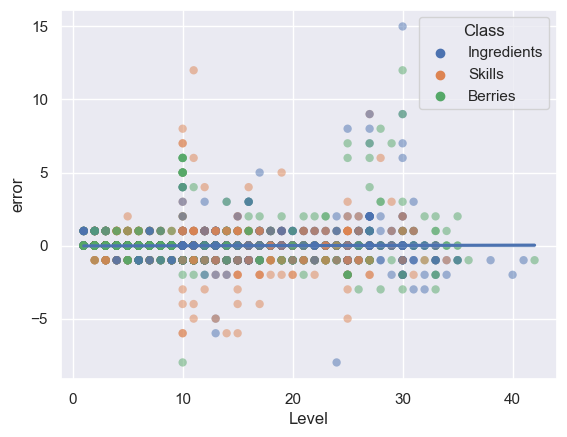

In [9]:
# Plot error vs level

err = df[["Level","error","Class"]]
palette = sns.color_palette(n_colors=3)

_ = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0, palette=palette)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

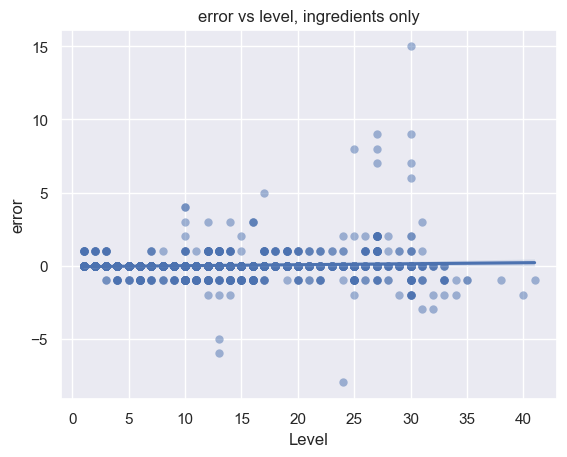

In [10]:
err2 = err[ err["Class"]=="Ingredients" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[0])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, ingredients only')


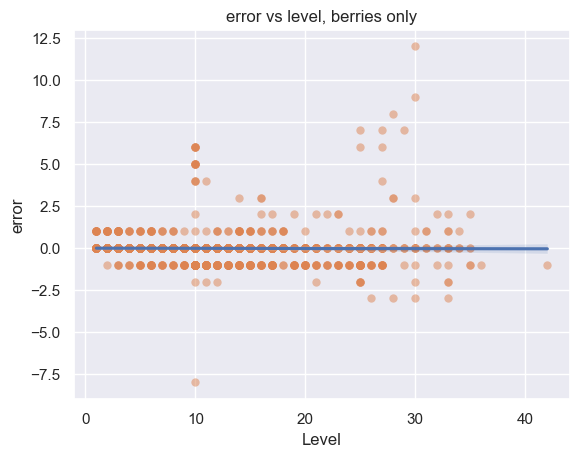

In [11]:
err2 = err[ err["Class"]=="Berries" ]
p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[1])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, berries only')

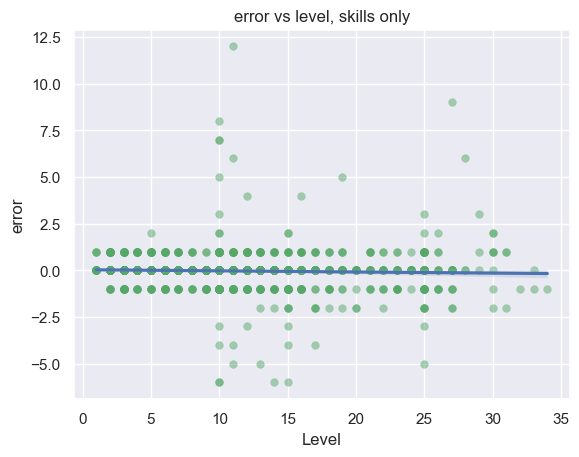

In [12]:
err2 = err[ err["Class"]=="Skills" ]

p = sns.scatterplot(data=err2, x="Level", y="error", alpha=0.5, linewidth=0, color=palette[2])
_ = sns.regplot(data=err2, x="Level", y="error", scatter=False)
_ = p.set(title='error vs level, skills only')


intercept,-0.00319486
intercept_stderr,0.015047
pvalue,0.0696315
rvalue,-0.0267733
slope,-0.00295243
stderr,0.00162693


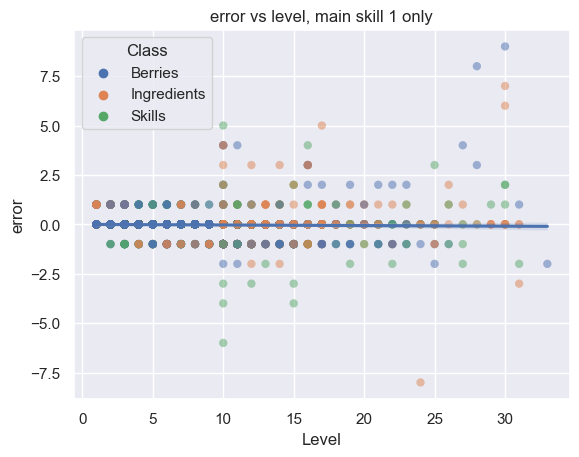

In [13]:
# Plot error vs level - focus on main skill 1

err = df[["Level","error","Class"]].loc[df["MS lvl"]==1]

p = sns.scatterplot(data=err, x="Level", y="error", hue="Class", alpha=0.5, linewidth=0)
_ = sns.regplot(data=err, x="Level", y="error", scatter=False)

_ = p.set(title='error vs level, main skill 1 only')

# What is the slope ?
linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

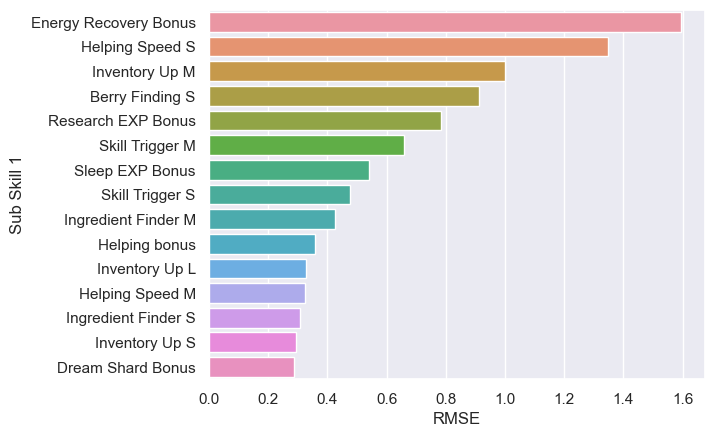

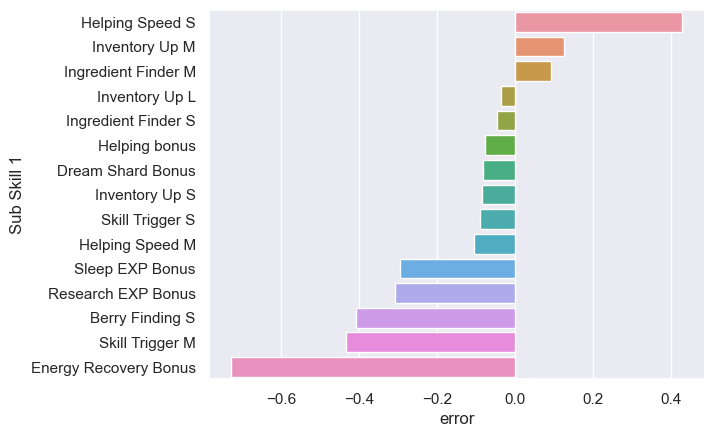

In [14]:
# Let's see what happens at level 10 and main skill 1

subskill_err = ( df[["Level", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]==10) & (df["MS lvl"]==1) ]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

subskill_err["RMSE"] = np.sqrt(subskill_err["error2"])

_ = plt.figure()
_ = sns.barplot(data=subskill_err, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=subskill_err.sort_values("error", ascending = False), y="Sub Skill 1", x="error")


intercept,-0.00319486
intercept_stderr,0.015047
pvalue,0.0696315
rvalue,-0.0267733
slope,-0.00295243
stderr,0.00162693


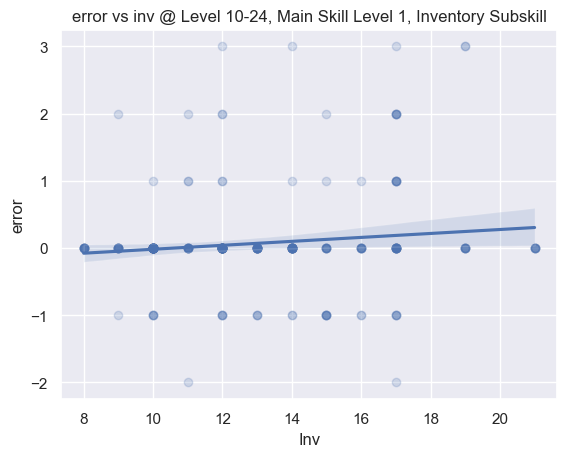

In [15]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"].str.contains("Inventory")) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

intercept,-0.00319486
intercept_stderr,0.015047
pvalue,0.0696315
rvalue,-0.0267733
slope,-0.00295243
stderr,0.00162693


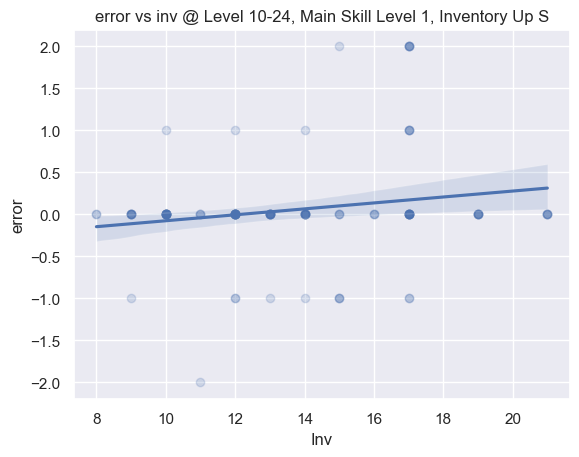

In [16]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]]
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up S" ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Up S')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

intercept,-0.00319486
intercept_stderr,0.015047
pvalue,0.0696315
rvalue,-0.0267733
slope,-0.00295243
stderr,0.00162693


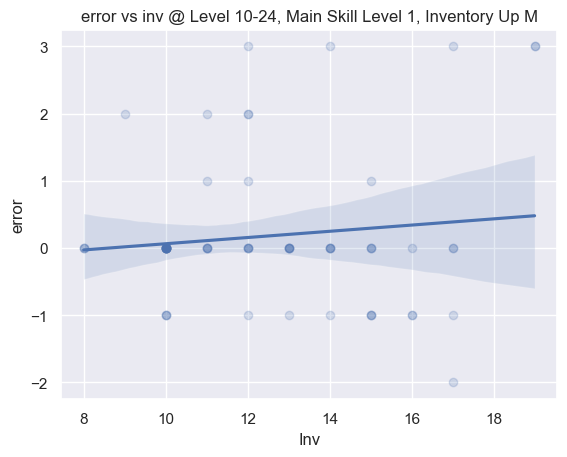

In [17]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]]
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up M" ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Up M')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

In [18]:
df[["Level", "Inv","NatureP","NatureN", "Sub Skill 1", "error", "error2"]].loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up M" )  & (df["error2"] > 1)]


,Level,Inv,NatureP,NatureN,Sub Skill 1,error,error2
3041,14.0,12.0,Energy Recovery,Main Skill Chance,Inventory Up M,3.0,9.0
2883,12.0,14.0,Energy Recovery,Main Skill Chance,Inventory Up M,3.0,9.0
2026,16.0,19.0,Energy Recovery,Ingredient Finding,Inventory Up M,3.0,9.0
2027,16.0,19.0,Energy Recovery,Main Skill Chance,Inventory Up M,3.0,9.0
2804,16.0,17.0,Energy Recovery,EXP Gains,Inventory Up M,3.0,9.0
383,16.0,11.0,Energy Recovery,Main Skill Chance,Inventory Up M,2.0,4.0
1825,12.0,17.0,Main Skill Chance,EXP Gains,Inventory Up M,-2.0,4.0
2523,10.0,12.0,Energy Recovery,Ingredient Finding,Inventory Up M,2.0,4.0
1591,10.0,9.0,Energy Recovery,Speed of Help,Inventory Up M,2.0,4.0
449,10.0,12.0,Energy Recovery,Main Skill Chance,Inventory Up M,2.0,4.0


intercept,-0.00319486
intercept_stderr,0.015047
pvalue,0.0696315
rvalue,-0.0267733
slope,-0.00295243
stderr,0.00162693


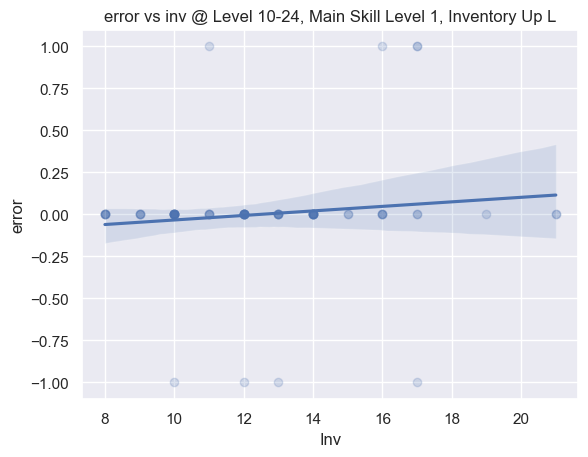

In [19]:
# Let's see what happens at level 10-24, main skill 1, and inventory bonus

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]]
                 .loc[ (df["Level"]<25) & (df["MS lvl"]==1) & ( df["Sub Skill 1"] == "Inventory Up L" ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

_ = p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Inventory Up L')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

[Text(0.5, 1.0, 'error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')]

intercept,-0.00319486
intercept_stderr,0.015047
pvalue,0.0696315
rvalue,-0.0267733
slope,-0.00295243
stderr,0.00162693


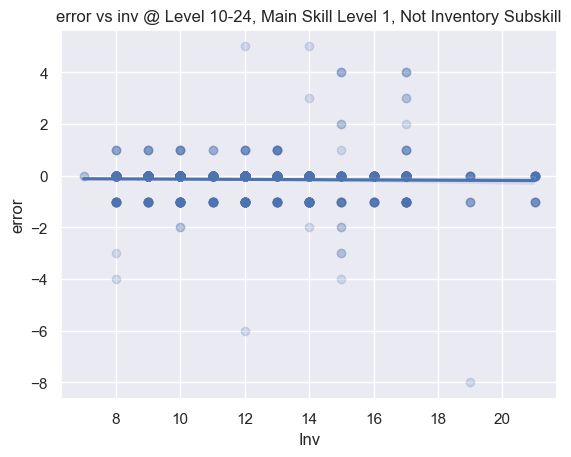

In [20]:
# Let's see what happens at level 10-24, main skill 1, and not inventory bonus 

inventory_err = ( df[["Level", "Inv", "Sub Skill 1", "error", "error2"]] 
                 .loc[ (df["Level"]>9) & (df["Level"]<25) & (df["MS lvl"]==1) & ( ~df["Sub Skill 1"].str.contains("Inventory") ) ]
                )

p = sns.regplot(data=inventory_err, x="Inv", y="error", x_jitter=0, scatter_kws={'alpha':0.2})

p.set(title='error vs inv @ Level 10-24, Main Skill Level 1, Not Inventory Subskill')

linearfit = scipy.stats.linregress(x=err["Level"], y=err["error"])
table(linearfit)

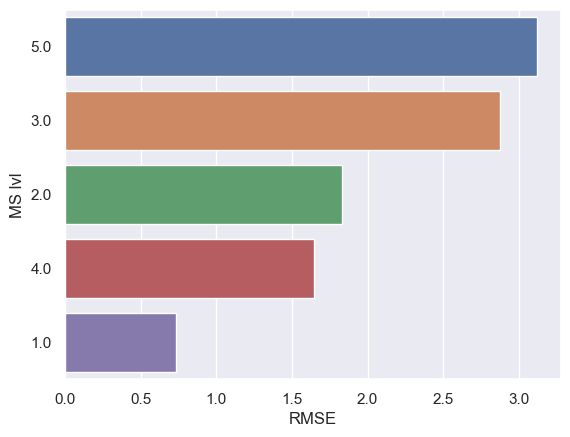

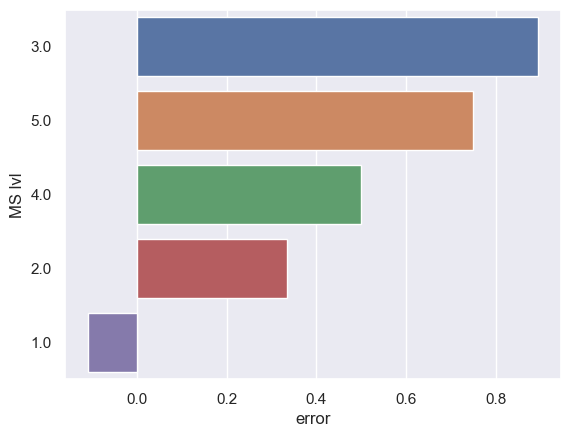

In [21]:
mslvl_err = ( df[["Level", "MS lvl", "error", "error2"]][df["Level"]==10]
                .groupby("MS lvl")
                .mean()
                .sort_values("error2", ascending = False)
                .reset_index() )

mslvl_err["RMSE"] = np.sqrt(mslvl_err["error2"])
mslvl_err["MS lvl"] = mslvl_err["MS lvl"].astype(str)

_ = plt.figure()
_ = sns.barplot(data=mslvl_err, y="MS lvl", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=mslvl_err.sort_values("error", ascending = False), y="MS lvl", x="error")


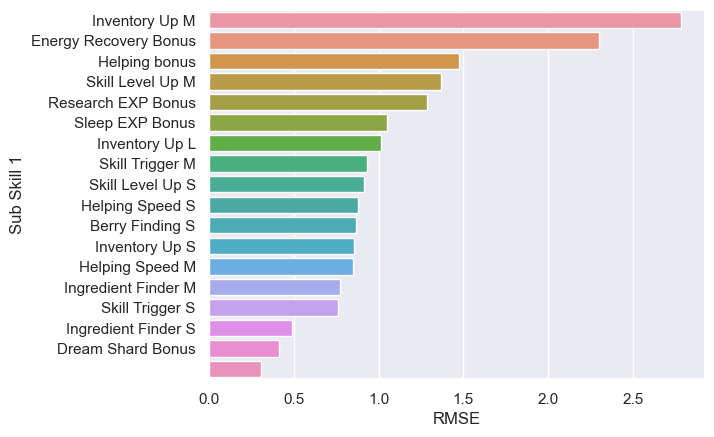

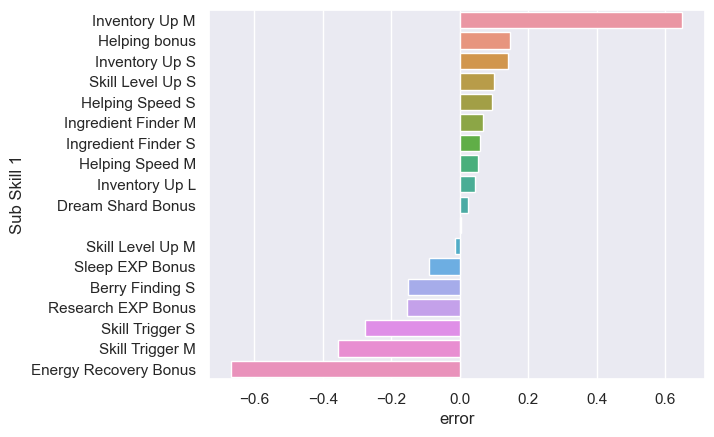

In [22]:
# Do we have more error in some skills ?

errorbyskill1 = (df[["Sub Skill 1","error","error2"]]
                .groupby("Sub Skill 1")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill1["RMSE"] = np.sqrt(errorbyskill1["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill1, y="Sub Skill 1", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill1.sort_values("error", ascending = False), y="Sub Skill 1", x="error")

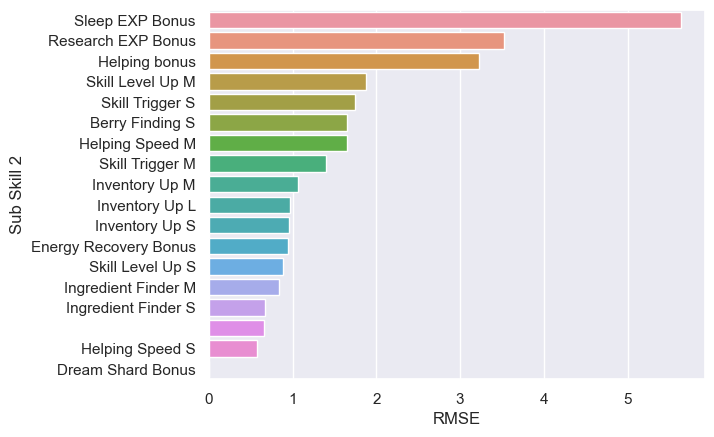

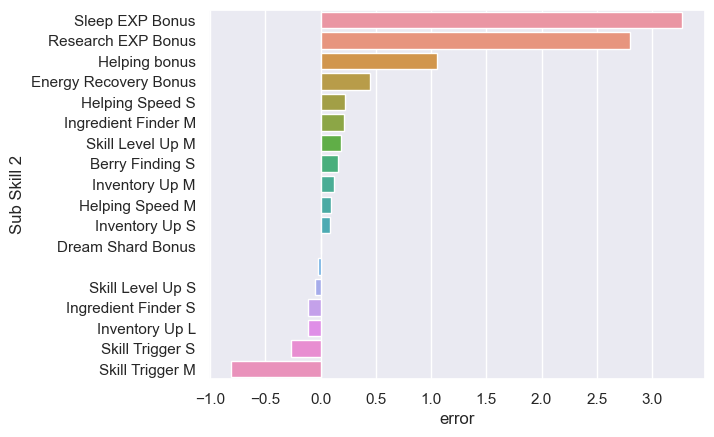

In [23]:
errorbyskill2 = (df[["Sub Skill 2","error","error2"]]
                .groupby("Sub Skill 2")
                .mean()
                .sort_values("error2", ascending = False)
                #.rename(columns={"error":"avg abs error"})
                .reset_index() )

errorbyskill2["RMSE"] = np.sqrt(errorbyskill2["error2"])
    
_ = plt.figure()
_ = sns.barplot(data=errorbyskill2, y="Sub Skill 2", x="RMSE")

_ = plt.figure()
_ = sns.barplot(data=errorbyskill2.sort_values("error", ascending = False), y="Sub Skill 2", x="error")